In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read some product review data

In [2]:
products = pd.read_csv("amazon_baby.csv")

# fill missing values with empty string
products.review.fillna("", inplace=True)

# Let's explore this data together

In [38]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

In [4]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


# Build the word count vector for each review

# Exploring the most popular product

In [5]:
products.name.value_counts().reset_index()

,index,name
0,Vulli Sophie the Giraffe Teether,785
1,"Simple Wishes Hands-Free Breastpump Bra, Pink,...",562
2,Infant Optics DXR-5 2.4 GHz Digital Video Baby...,561
3,Baby Einstein Take Along Tunes,547
4,"Cloud b Twilight Constellation Night Light, Tu...",520
...,...,...
32412,Baby Blanket 30 X 35 Inches by Unique Baby (Iv...,1
32413,Bugaboo Frog Stroller - Orange,1
32414,"OXO Tot Sprout Chair Replacement Cushion Set, ...",1
32415,Elmo Travel Tray,1


# Explore Vulli Sophie

In [3]:
giraffe_reviews = products.loc[products.name == 'Vulli Sophie the Giraffe Teether', ]

In [4]:
len(giraffe_reviews)

785

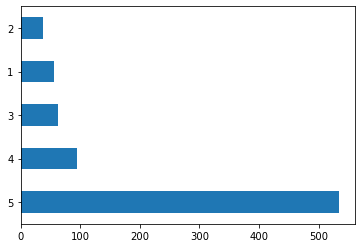

In [5]:
giraffe_reviews.rating.value_counts().plot(kind='barh')
plt.show()

# Build a sentiment classifier

In [9]:
products.rating.describe()

count    183531.000000
mean          4.120448
std           1.285017
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

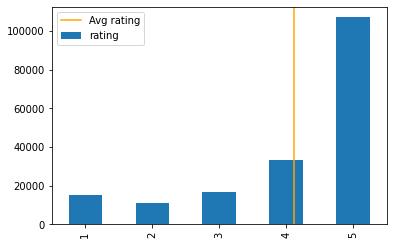

In [12]:
avg_rating = products.rating.mean() - 1 # because ticks starts from "0"
products.rating.value_counts().sort_index().plot(kind='bar')
plt.axvline(avg_rating, color='orange', label='Avg rating')
plt.legend()
plt.show()

## Define what's a positive and a negative sentiment

In [6]:
# ignore all 3* reviews
products = products[products.rating != 3]

# add sentiment column
products['sentiment'] = products.rating >= 4
products.sentiment = products.sentiment.astype('int')

In [7]:
products.head()

,name,review,rating,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,1


# Let's train the sentiment classidier

In [8]:
# we'll use the CountVectorizer to count each vocabulary and put it into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline

In [9]:
pipe = make_pipeline(CountVectorizer(), LogisticRegression(solver='lbfgs', max_iter=150))

In [18]:
pipe

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=150))])

In [10]:
X = products.review
y = products.sentiment

In [11]:
# split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [12]:
# fit the pipeline to the train dataset
pipe.fit(X_train, y_train)

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=150))])

In [13]:
y_pred = pipe.predict(X_test)

**Accuracy Score**: percentage of correct predictions

In [14]:
metrics.accuracy_score(y_test, y_pred)

0.9319960420976883

**Null accuracy**: accuracy that could be achieved by always predicting the most frequent class

In [15]:
products.sentiment.value_counts()[1] / len(products)

0.8411233448474381

## Confusion matrix
Table that describes the perfomance of a clasification model

In [16]:
cm = metrics.confusion_matrix(y_test, y_pred)

In [17]:
pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
Actual 0,3852,1447
Actual 1,821,27231


In [18]:
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).reshape(1, -1)[0]

**Classification Error**: Overall, how oftenis the classifier incorrect?

In [19]:
(FP + FN) / (FP + FN + TN + TP) # or you can find this by 1 - accuracy_score

0.06800395790231177

**Sensitivity**: When the actual value is positive, how often is the prediction correct?
* How "sensitive" is the clasifier to detection positive instances?
* Also known as **True Positive Rate** or **Recall**?

In [20]:
print(TP / (TP + FN))
print(metrics.recall_score(y_test, y_pred))

0.9707329245686582
0.9707329245686582


**False Positive Rate**: When the acutal value is negative, how often is the prediction incorrect?

In [21]:
FP / (FP + TN)

0.27307039063974337

**Precision**: When a positive value is predicted, how often is the prediction correct?

In [22]:
print(TP / (TP + FP))
print(metrics.precision_score(y_test, y_pred))

0.9495432038496409
0.9495432038496409


In [23]:
# print the first ten predicted responses
pipe.predict(X_test)[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
# print the first ten predicted probabilities for class 1
pipe.predict_proba(X_test)[:, 1]

array([0.99999777, 0.51578958, 0.99976361, ..., 0.91836695, 0.35159937,
       0.99999099])

In [25]:
# store the predicted probabilities for class 1
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

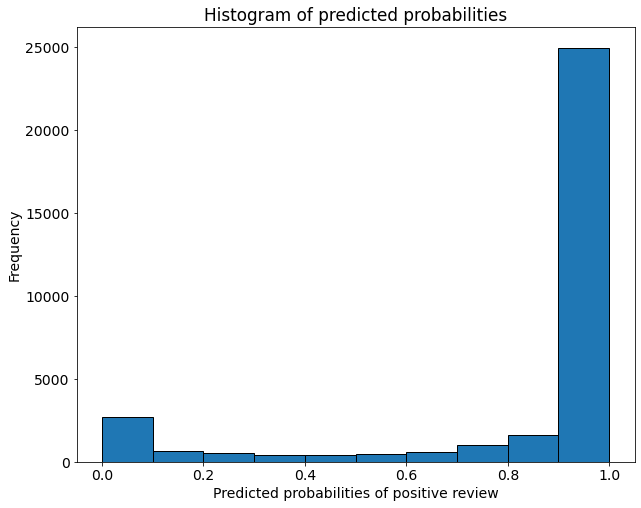

In [26]:
plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 8))

plt.hist(y_pred_proba, edgecolor='black')
plt.title("Histogram of predicted probabilities")
plt.xlabel("Predicted probabilities of positive review")
plt.ylabel("Frequency")
plt.show()

# Evaluate the sentiment model

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

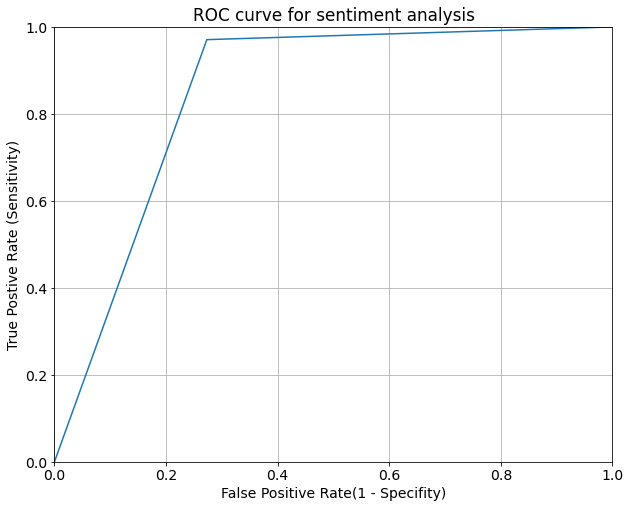

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC curve for sentiment analysis")
plt.xlabel("False Positive Rate(1 - Specifity)")
plt.ylabel("True Postive Rate (Sensitivity)")
plt.grid(True)
plt.show()

# Applying the learned model to understand sentiment for Giraffe

In [29]:
y_pred_proba = pipe.predict_proba(giraffe_reviews.review)[:, 1]

In [30]:
# reset the index for girafe_reviews dataframe and drop index column
giraffe_reviews = giraffe_reviews.reset_index(drop=True)

# append the probability to its dataframe
giraffe_reviews = pd.concat([giraffe_reviews, pd.Series(y_pred_proba, name='predicted_sentiment')], axis=1)

In [50]:
giraffe_reviews.head()

,name,review,rating,predicted_sentiment
0,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,0.998731
1,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,0.999150
2,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,0.606056
3,Vulli Sophie the Giraffe Teether,All the moms in my moms' group got Sophie for ...,5,0.971377
4,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,0.698227


## Sort the reviews based on the predicted sentiment and explore

In [31]:
# sort by 'rating'; ascending False
giraffe_reviews = giraffe_reviews.sort_values(by='predicted_sentiment', ascending=False).reset_index()

## Explore the most positive

In [32]:
giraffe_reviews.loc[0, 'review']

"Sophie, oh Sophie, your time has come. My granddaughter, Violet is 5 months old and starting to teeth. What joy little Sophie brings to Violet. Sophie is made of a very pliable rubber that is sturdy but not tough. It is quite easy for Violet to twist Sophie into unheard of positions to get Sophie into her mouth. The little nose and hooves fit perfectly into small mouths, and the drooling has purpose. The paint on Sophie is food quality.Sophie was born in 1961 in France. The maker had wondered why there was nothing available for babies and made Sophie from the finest rubber, phthalate-free on St Sophie's Day, thus the name was born. Since that time millions of Sophie's populate the world. She is soft and for babies little hands easy to grasp. Violet especially loves the bumpy head and horns of Sophie. Sophie has a long neck that easy to grasp and twist. She has lovely, sizable spots that attract Violet's attention. Sophie has happy little squeaks that bring squeals of delight from Viol

In [33]:
giraffe_reviews.loc[1, 'review']

'My Mom-in-Law bought Sophie for my son when he was just starting to really chew on things (and we were hearing some pretty scary things about toys not made in the USA). She did some research and came across Sophie and we are so glad that she did! While Sophie doesn\'t come from the USA, we love the fact that she is 100% safe and natural, and my son loves to play with her. I also love how soft Sophie is, my son tends to swing his toys around and when he\'s sitting on my lap I\'m usually in danger of being hit in the face with whatever he\'s holding, needless to say a soft toy is even better in my book! There\'s one last thing I want to comment on, I\'ve read reviews that said that Sophie was a "glorified dog toy" or something to that effect, and I don\'t want to seem rude, but I think they\'re crazy! Yes Sophie does squeak, (which my son didn\'t care about much at first but now he loves) but that\'s about as far as the comparison could go! If you want a quality teething toy for your ch

## Show the most negative reviews

In [34]:
review = -3
giraffe_reviews.iloc[-1, review]

'I wanted to love this product and was excited to buy it when I became pregnant but am now hesitant to let my baby use it after reading about the recall in Europe. Apparently, as I understand it, their toxin standards of measurement are lower than ours so they have not been recalled here (apparently we are OK with low levels of nitrates in the toys our children put in their mouths, but Europeans are not...hmmm)...Be that as it may, toxins registering even CLOSE to a dangerous level made me nervous about using. After digging around online I did discover that the company claims to have changed the product after a certain date and lists manufacturing codes so you can check yours (those listed were made after a certain date and are said to be safer). Sadly mine was not made after the &#34;improved&#34; date but I could not return it because there was no formal recall in our country. I considered returning it and hunting for one with an approved manufacturing date but man that was just too 

In [35]:
giraffe_reviews.iloc[-2, review]

"I got one of these as a showe gift that my baby loves. I wanted to buy another and saw it on Amazon for $19. What a deal considering these are normally $25. So I ordered and am not sure if it's the same and if the one from Amazon is authentic.I realize these are hand painted so there will be variation. But the rubber on the new one smells different and feels slightly harder than my original one. There are also some rough spots on the Amazon one whereas there were no rough spots on my original one at all as you could plainly tell it was very high quality. The sqeaker is not the same in the two versions. When you press on it to feel it, the shape of the squeaker is different shape, size, and sound. My original one squeaks better. The one from Amazon doesn't squeak well, and is higher pitched. The serial number font size on the two are different. The original one had a larger font size and the Amazon has a smaller font size. The most notable difference is the feet/hooves. The original on